In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Problem 1

In [88]:
#Read csv data file and drop the first column
all_data = pd.read_csv("DailyReturn.csv")
all_data = all_data.drop("Unnamed: 0",axis=1)

In [89]:
all_data.head()

,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,BRK-B,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
0,-0.003269,0.001423,-0.000136,0.012222,0.018326,0.009260,0.008723,-0.008426,0.013278,-0.015228,...,-0.013455,-0.008396,-0.005559,0.000520,-0.015466,-0.023272,-0.004768,-0.008806,-0.009122,-0.010335
1,0.016127,0.023152,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,0.006109,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028571,0.013237
2,0.001121,-0.001389,-0.001167,0.010159,0.001041,0.008268,0.007784,-0.020181,0.000604,-0.001739,...,0.006757,-0.002429,0.005763,0.038879,0.009294,0.012244,0.003363,0.015301,-0.001389,-0.025983
3,-0.021361,-0.021269,-0.029282,-0.021809,-0.050943,-0.037746,-0.037669,-0.040778,-0.075591,-0.006653,...,-0.034949,0.005326,0.015017,-0.046988,-0.009855,0.004833,-0.030856,-0.031925,-0.033380,-0.028763
4,-0.006475,-0.009356,-0.009631,-0.013262,-0.022103,-0.016116,-0.013914,-0.007462,-0.035296,0.003987,...,-0.000646,-0.000908,0.007203,-0.000436,-0.003916,-0.005942,-0.013674,-0.004506,-0.003677,0.015038


In [90]:
def expo_weighted_cov(ret_data, w_lambda):
    weight = np.zeros(ret_data.shape[0]) # create a vector with num of rows corresponding to the periods of time, so we can attach weight to each time point
    for i in range(len(ret_data)):
        weight[len(ret_data)-1-i]  = (1-w_lambda)*w_lambda**i # weight for each time point will be decided by lambda set
    weight = weight/sum(weight) # assure that sum_weight == 1
    adj_ret_means = ret_data - ret_data.mean()
    expo_w_cov = adj_ret_means.T @ np.diag(weight) @ adj_ret_means # cov(x, x) = sum(wt * (xt - miux) * (xt - miux))
    return expo_w_cov

cov_mtx = expo_weighted_cov(all_data, 0.97).values
print(cov_mtx)


[[1.55382269e-04 2.09647082e-04 2.34621476e-04 ... 2.09131805e-04
  1.60236470e-04 6.30835084e-05]
 [2.09647082e-04 4.20670357e-04 3.20731274e-04 ... 2.86261481e-04
  2.01070219e-04 6.38376883e-05]
 [2.34621476e-04 3.20731274e-04 4.99230102e-04 ... 2.96918713e-04
  1.92369511e-04 3.85098812e-05]
 ...
 [2.09131805e-04 2.86261481e-04 2.96918713e-04 ... 7.15800762e-04
  2.13314178e-04 6.43298058e-05]
 [1.60236470e-04 2.01070219e-04 1.92369511e-04 ... 2.13314178e-04
  3.25441366e-04 7.25937608e-05]
 [6.30835084e-05 6.38376883e-05 3.85098812e-05 ... 6.43298058e-05
  7.25937608e-05 1.70423991e-04]]


In [91]:
# implement PCA to calculate the cumulative variance explained by eigenvalues
def pca(cov_mtx, n_eigenvalues):
    eigenvalues, eigenvectors = np.linalg.eig(cov_mtx) # decompose the vector
    p_idx = eigenvalues > 0 # keep track of the eigenvalues that are positive
    pos_eigenvalues = eigenvalues[p_idx] # pick only positive ones for eigenvalues
    pos_eigenvectors = eigenvectors[:, p_idx] # pick only those corresponding positive ones for eigenvectors
    s_idx = np.argsort(pos_eigenvalues)[::-1] # sort in descending order, so the very first ones are the most important
    sort_eigenvalues = pos_eigenvalues[s_idx] # the first nth eigenvalue and eigenvectors is what we want
    sort_eigenvectors = pos_eigenvectors[:, s_idx]

    cum_var = np.sum(sort_eigenvalues[0:n_eigenvalues]) / np.sum(sort_eigenvalues) # explained variance / all variance
    return cum_var

# print(pca(cov_mtx, 40))

/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


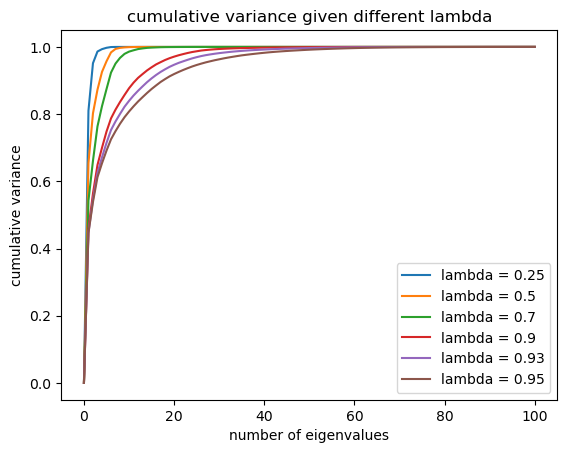

In [92]:
#Make plot
lambdas = [0.25, 0.5, 0.7, 0.9, 0.93, 0.95]
for w_lambda in lambdas:
    cov_mtx = expo_weighted_cov(all_data, w_lambda)
    cul_var = []
    for i in range(101):
        cul_var.append(pca(cov_mtx, i))
    plt.plot(cul_var, label = f"lambda = {w_lambda}")
    plt.xlabel("number of eigenvalues")
    plt.ylabel("cumulative variance")
    plt.title("cumulative variance given different lambda")
    plt.legend()

## Problem 2

In [117]:
# cov_mtx = expo_weighted_cov(all_data, 0.97)

def chol_psd(cov_matrix):
    # cov_mtx = cov_matrix.values # we do this to obtain the pure value of covariance metrics and not bug for stock names
    cov_mtx = cov_matrix
    n = cov_mtx.shape[0] # initialize the root matrix with 0 values
    root = np.zeros_like(cov_mtx)
    for j in range(n): # loop over columns
        s = 0.0
        if j > 0: # if we are not on the first column, calculate the dot product of the preceding row values
            s = np.dot(root[j, :j], root[j, :j])
        temp = cov_mtx[j, j] - s
        if 0 >= temp >= -1e-8:
            temp = 0.0
        root[j, j] = np.sqrt(temp)
        if root[j, j] == 0.0: # diagonal elements
            for i in range(j + 1, n):
                root[i, j] = 0.0
        else: # update off diagonal rows of the column
            ir = 1.0 / root[j, j]
            for i in range(j + 1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (cov_mtx[i, j] - s) * ir
    return root

# print(chol_psd(cov_mtx))

In [94]:
# Rebonato and Jackel deal with non-PSD matrix
def near_psd(mtx, epsilon=0.0):
    n = mtx.shape[0]

    invSD = None
    out = mtx.copy()

    # calculate the correlation matrix if we got a covariance
    if (np.diag(out) == 1.0).sum() != n:
        invSD = np.diag(1 / np.sqrt(np.diag(out)))
        out = invSD.dot(out).dot(invSD)

    # SVD, update the eigen value and scale
    vals, vecs = np.linalg.eigh(out)
    vals = np.maximum(vals, epsilon)
    T = np.reciprocal(np.square(vecs).dot(vals))
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T.dot(vecs).dot(l)
    out = np.matmul(B, np.transpose(B))
    # we don't directly do S*lambda*S' as in this way we would have diagonal elements != 1

    # Add back to the correlation matrix to get covariance matrix
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        out = invSD.dot(out).dot(invSD)

    return out

In [95]:
#Calculate Frobenius Norm
def fnorm(mtxa, mtxb):
    s = mtxa - mtxb
    norm = 0
    for i in range(len(s)):
        for j in range(len(s[0])):
            norm +=s[i][j]**2
    return norm

In [151]:
# Higham deal with non-PSD matrix
def Pu(mtx): # the projection to make the input matrix's diagonal elements to all be one
    new_mtx = mtx.copy()
    for i in range(len(mtx)):
        for j in range(len(mtx[0])):
            if i == j:
                new_mtx[i][j] = 1
    return new_mtx

def Ps(mtx, w): # the projection to make the input non-PSD matrix to PSD matrix
    mtx = np.sqrt(w) @ mtx @ np.sqrt(w)
    vals, vecs = np.linalg.eigh(mtx)
    vals = np.array([max(i,0) for i in vals])
    new_mtx = np.sqrt(w)@ vecs @ np.diag(vals) @ vecs.T @ np.sqrt(w)
    return new_mtx

def higham_psd(mtx, w, max_iteration = 1000): # w as weight is added to allow variation in matrix weight so you can attach different importance to different value, max_iteration is to prevent possible infinite loop
    r0 = np.inf
    Y = mtx
    S = np.zeros_like(Y)

    # calculate the correlation matrix if we got a covariance, it is a norm, we don't do PSD adjustion on covariance matrix
    invSD = None
    if np.count_nonzero(np.diag(Y) == 1.0) != mtx.shape[0]:
        invSD = np.diag(1.0 / np.sqrt(np.diag(Y)))
        Y = invSD.dot(Y).dot(invSD)
    C = Y.copy()

    # just do exactly as the pdf shows, reasoning details can be found in the manchester prof's paper
    for i in range(max_iteration):
        R = Y - S
        X = Ps(R, w)
        S = X - R
        Y = Pu(X)
        r = fnorm(Y, C) # use Frobenius Norm to calculate difference
        minval = np.linalg.eigvals(Y).min()
        tol = 1e-8 # tol as tolerance to see whether the difference between matrices are converging, set to be a very small positive value
        if abs(r - r0) < tol and minval > -1e-8: # if it is converging, we will consider the difference between input non PSD matrix and output PSD matrix is small enough and break from the loop
        # minval is used to ensure non negative values, delete this would cause higham ends before matrix turning PSD
            break
        else:
            r0 = r

    # Add back to the correlation matrix to get covariance matrix
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        Y = invSD.dot(Y).dot(invSD)
    return Y

In [146]:
# generate a non-psd correlation matrix that is 500x500, copied from pdf, just to test, actual implementation would be in the loop
n = 500
sigma_test = np.full((n,n),0.9)
for i in range(n):
    sigma_test[i,i]=1.0
sigma_test[0,1] = 0.7357
sigma_test[1,0] = 0.7357

In [147]:
def is_psd(mtx):
    eigenvalues = np.linalg.eigh(mtx)[0] # this returns both eigenvalues and eigenvectors, while ensure real numbers, better than np.linalg.eigvals()
    return np.all(eigenvalues >= -1e-8) # if all elements in the matrix are positive, return true, which indicates input is PSD matrix; if not so, return false which indicates input is not PSD matrix

In [152]:
print(is_psd(sigma_test))
sigma_test_near = near_psd(sigma_test)
print(is_psd(sigma_test_near))
weight = np.identity(len(sigma_test))
sigma_test_higham = higham_psd(sigma_test, weight)
print(is_psd(sigma_test_higham))

False
True
True


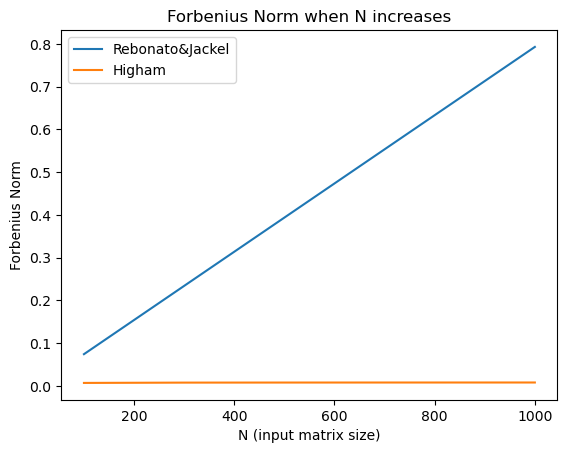

In [153]:
# Compare the Frobenius Norm between near_psd and higham
range_n = [100, 300, 500, 700, 1000] # used to create correlation matrix of different sizes

fnorms_near = [] # array to store fnorms value for method near_psd()
fnorms_higham = [] # array to store fnorms value for method higham()
for n in range_n: # create correlation matrix (we could do covariance matrix as near_psd() and higham() would accept them, but in this way it is faster)
    sigma = np.full((n,n), 0.9)
    for i in range(n):
        sigma[i,i] = 1.0
    sigma[0,1] = 0.7357
    sigma[1,0] = 0.7357

    sigma_near = near_psd(sigma)
    near_norm = fnorm(sigma, sigma_near) # calculate the difference between sigma and transformed sigma using near_psd
    fnorms_near.append(near_norm)

    weight = np.identity(len(sigma)) # we do identity matrix here, as we don't want to attach different importance to different value
    sigma_higham = higham_psd(sigma, weight)
    higham_norm = fnorm(sigma, sigma_higham) # calculate the difference between sigma and transformed sigma using higham
    fnorms_higham.append(higham_norm)

plt.plot(range_n,fnorms_near, label = "Rebonato&Jackel")
plt.plot(range_n,fnorms_higham, label = "Higham")
plt.xlabel("N (input matrix size)")
plt.ylabel("Forbenius Norm")
plt.title("Forbenius Norm when N increases")
plt.legend()

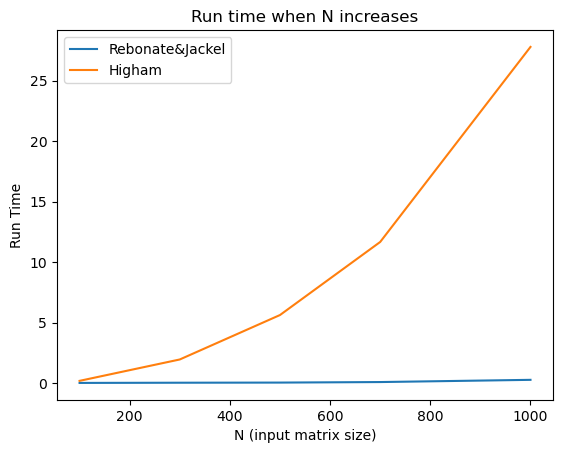

In [154]:
# compare the run time between near_psd and higham
t_near = []
t_higham =[]
for n in range_n: # same creation process for correlation matrix
    sigma = np.full((n,n),0.9)
    for i in range(n):
        sigma[i,i]=1.0
    sigma[0,1] = 0.7357
    sigma[1,0] = 0.7357

    start_time_near = time.time()
    sigma_near = near_psd(sigma)
    stop_time_near = time.time()
    run_time_near = stop_time_near - start_time_near # calculate run time for matrix transformation through near_psd()
    t_near.append(run_time_near)

    weight = np.identity(len(sigma)) # prepare the identity matrix beforehand to avoid its influence to run time

    start_time_higham = time.time()
    sigma_higham = higham_psd(sigma, weight)
    stop_time_higham = time.time()
    run_time_higham = stop_time_higham - start_time_higham # calculate the run time for matrix transformation through higham()
    t_higham.append(run_time_higham)

plt.plot(range_n,t_near, label = "Rebonate&Jackel")
plt.plot(range_n,t_higham, label = "Higham")
plt.xlabel("N (input matrix size)")
plt.ylabel("Run Time")
plt.title("Run time when N increases")
plt.legend()

## Problem 3

In [118]:
# multivariate simulation - directly from a covariance matrix
def simu_from_cov(cov_mtx, num_samples, mean = None):
    if mean is None: # allows variation of mean vector, if not valid input for this, the default value is zero
        mean = np.zeros(cov_mtx.shape[0])

    chol_decomp = chol_psd(cov_mtx)
    std_norm_samples = np.random.randn(num_samples, cov_mtx.shape[0])

    samples = mean + np.dot(std_norm_samples, chol_decomp.T)
    return samples

simulations0 = simu_from_cov(np.cov(all_data.T), 25000)
print(simulations0)

[[ 1.09258058e-02  8.12271407e-03  2.19325336e-03 ...  3.01013371e-02
   1.37975423e-02  2.02649803e-02]
 [ 1.07421704e-02  1.33471605e-02  6.81444262e-03 ...  3.19525419e-02
   1.47818821e-02  1.92321268e-02]
 [ 1.07272324e-02  1.51412318e-02  1.70514126e-02 ...  6.96178404e-03
   3.56253990e-03 -2.77519710e-03]
 ...
 [ 2.30790256e-03 -1.87459739e-05  5.96032343e-03 ... -9.01174447e-03
   6.22833641e-04 -1.40739611e-03]
 [ 1.28340685e-02  1.95742716e-02  1.95547702e-02 ...  8.54731599e-03
   8.50159922e-03  1.37812287e-02]
 [-2.13916069e-02 -2.97618440e-02 -3.21326743e-02 ... -1.78721948e-02
  -4.64489974e-02 -1.81116422e-02]]


In [99]:
def pca_percent_explain(sort_eigenvalues, percent_explain):
    n_eigenvalues = 0
    cum_var = np.cumsum(sort_eigenvalues) / np.sum(sort_eigenvalues) # returns an array with the variance explained by elements from 1st to 1st / 2nd / 3rd / 4th...
    for i in range(len(cum_var)):
        if cum_var[i] >= percent_explain:
            n_eigenvalues = i + 1
            break
    return n_eigenvalues

In [100]:
# multivariate simulation - using PCA of which % variance explained as an input
def simu_from_pca(cov_mtx, num_samples, percent_explain):
    eigenvalues, eigenvectors = np.linalg.eig(cov_mtx)
    p_idx = eigenvalues > 0 # only want those eigenvalues are non 0, as if it is zero, we remove everything related to that, including the eigenvalue in matrix lambda and its corresponding column in the
    # p_idx will return a numpy array of boolean values, indicating which eigenvalue is positive, and which eigenvalue is not
    pos_eigenvalues = eigenvalues[p_idx]
    pos_eigenvectors = eigenvectors[:, p_idx]
    # sort in descending order
    s_idx = np.argsort(pos_eigenvalues)[::-1] # return an array indicating the sequence for original input array
    sort_eigenvalues = eigenvalues[s_idx] # rearrange the eigenvalue array
    sort_eigenvectors = eigenvectors[:, s_idx] # rearrange the column of eigenvector corresponding to the change in eigenvalue array
    n_eigenvalues = pca_percent_explain(sort_eigenvalues, percent_explain)
    # print(n_eigenvalues)
    explain_eigenvalues = sort_eigenvalues[:n_eigenvalues] # only need the required eigenvalues enough to explain % set
    explain_eigenvectors = sort_eigenvectors[:,:n_eigenvalues] # only need the required eigenvectors enough to explain % set
    # np.random.seed(42)
    std_normals = np.random.normal(size=(n_eigenvalues, num_samples))

    # actual simulation
    sqrt_eigenvalues = np.sqrt(explain_eigenvalues) # calculate the square root of significant eigenvalues
    diag_sqrt_eigenvalues = np.diag(sqrt_eigenvalues) # create a diagonal matrix from the square root of eigenvalues
    transformation_matrix = np.dot(explain_eigenvectors, diag_sqrt_eigenvalues) # compute the transformation matrix 'B'
    multivariate_normal_samples = np.dot(transformation_matrix, std_normals) # generate the multivariate normal samples
    samples = np.transpose(multivariate_normal_samples) # transpose the result for the final output
    return samples

# simulations1 = simu_pca(np.cov(all_data.T), 25000, 0.75)
# print(simulations1)

In [109]:
# covariance matrix obtained through exponential weight variance vector and exponential weight correlation matrix
ew_var_ew_cor = expo_weighted_cov(all_data, 0.97).values
# print("ew_cov:")
# print(ew_var_ew_cor)

# covariance matrix obtained through pearson variance vector and pearson correlation matrix
ps_var_ps_cor = np.cov(all_data.T)
# print("ps_cov:")
# print(ps_var_ps_cor)

# covariance matrix obtained through exponential weight variance vector and pearson correlation matrix
def cal_ew_var_ps_cor(ret_data, w_lambda = 0.97):
    ew_cov = expo_weighted_cov(ret_data, w_lambda).values # get exponential weight covariance matrix
    ew_var = np.diag(ew_cov) # extract exponential weight variance vector
    D_sqrt = np.diag(np.sqrt(ew_var)) # get D^1/2

    ps_cor = ret_data.corr()
    ew_var_ps_cor = np.dot(D_sqrt, np.dot(ps_cor, D_sqrt)) # D @ cor @ D'
    return ew_var_ps_cor

ew_var_ps_cor = cal_ew_var_ps_cor(all_data)
# print("ew_var_ps_cor:")
# print(ew_var_ps_cor)

# covariance matrix obtained through pearson weight variance vector and exponential weight correlation matrix
def cal_ps_var_ew_cor(ret_data, w_lambda = 0.97):
    ps_cov = ret_data.cov()
    ps_var = np.diagonal(ps_cov) # extract pearson variance vector
    D_sqrt = np.diag(np.sqrt(ps_var)) # get D^1/2

    ew_cov = expo_weighted_cov(ret_data, w_lambda)
    invSD = np.diag(np.reciprocal(np.sqrt(np.diag(ew_cov))))
    ew_cor = invSD.dot(ew_cov).dot(invSD)
    ps_var_ew_cor = np.dot(D_sqrt, np.dot(ew_cor, D_sqrt)) # D @ cor @ D'
    return ps_var_ew_cor

ps_var_ew_cor = cal_ps_var_ew_cor(all_data)
# print("ps_var_ew_cor:")
# print(ps_var_ew_cor)

ew_cov:
[[1.55382269e-04 2.09647082e-04 2.34621476e-04 ... 2.09131805e-04
  1.60236470e-04 6.30835084e-05]
 [2.09647082e-04 4.20670357e-04 3.20731274e-04 ... 2.86261481e-04
  2.01070219e-04 6.38376883e-05]
 [2.34621476e-04 3.20731274e-04 4.99230102e-04 ... 2.96918713e-04
  1.92369511e-04 3.85098812e-05]
 ...
 [2.09131805e-04 2.86261481e-04 2.96918713e-04 ... 7.15800762e-04
  2.13314178e-04 6.43298058e-05]
 [1.60236470e-04 2.01070219e-04 1.92369511e-04 ... 2.13314178e-04
  3.25441366e-04 7.25937608e-05]
 [6.30835084e-05 6.38376883e-05 3.85098812e-05 ... 6.43298058e-05
  7.25937608e-05 1.70423991e-04]]
ps_cov:
[[0.00023    0.00029835 0.00029713 ... 0.00031866 0.00022311 0.00019008]
 [0.00029835 0.00050146 0.00040683 ... 0.00040356 0.00026005 0.00021191]
 [0.00029713 0.00040683 0.00050525 ... 0.0003796  0.00025325 0.00021619]
 ...
 [0.00031866 0.00040356 0.0003796  ... 0.00077183 0.00033463 0.00030005]
 [0.00022311 0.00026005 0.00025325 ... 0.00033463 0.00041174 0.00022401]
 [0.00019008 0

In [119]:
def direct_sim(cov_mtx, num_samples = 25000):
    start_time = time.time()
    simulations = simu_from_cov(cov_mtx, num_samples)
    # the output simulations is that each row is a new observation and each column corresponds to a different variable (dimension)
    stop_time = time.time()
    run_time = stop_time - start_time
    sim_cov_mtx = np.cov(simulations.T)
    # the np.cov() function calculates the covariance matrix where each row is considered a different variable, and columns are considered observations of those variables
    l2_norm = fnorm(sim_cov_mtx, cov_mtx)
    return run_time, l2_norm
# print(direct_sim(ps_var_ps_cor))

(0.1311190128326416, 2.1024781552365573e-07)


In [121]:
def pca_sim(cov_mtx, percent_explain, num_samples = 25000):
    start_time = time.time()
    simulations = simu_from_pca(cov_mtx, num_samples, percent_explain)
    stop_time = time.time()
    run_time = stop_time - start_time
    sim_cov_mtx = np.cov(simulations.T)
    l2_norm = fnorm(sim_cov_mtx, cov_mtx)
    return run_time, l2_norm
# print(pca_sim(ps_var_ps_cor, 0.75))

(0.08529806137084961, 3.3983049871376256e-06)


In [122]:
t1, f1 = direct_sim(ps_var_ps_cor)
t2, f2 = pca_sim(ps_var_ps_cor, 1)
t3, f3 = pca_sim(ps_var_ps_cor, 0.75)
t4, f4 = pca_sim(ps_var_ps_cor, 0.5)
run_time_ps_var_ps_cor = [t1, t2, t3, t4]
l2_norm_ps_var_ps_cor = [f1, f2, f3, f4]
print(run_time_ps_var_ps_cor)
print(l2_norm_ps_var_ps_cor)

run_time_ew_var_ew_cor = []
l2_norm_ew_var_ew_cor = []

run_time_ew_var_ps_cor = []
l2_norm_ew_var_ps_cor = []

run_time_ps_var_ew_cor = []
l2_norm_ps_var_ew_cor = []

[0.3148958683013916, 0.11126875877380371, 0.025556087493896484, 0.011672019958496094]
[1.2090621564354876e-07, 8.094637340833629e-08, 3.7021894494044706e-06, 2.3401525079225263e-05]


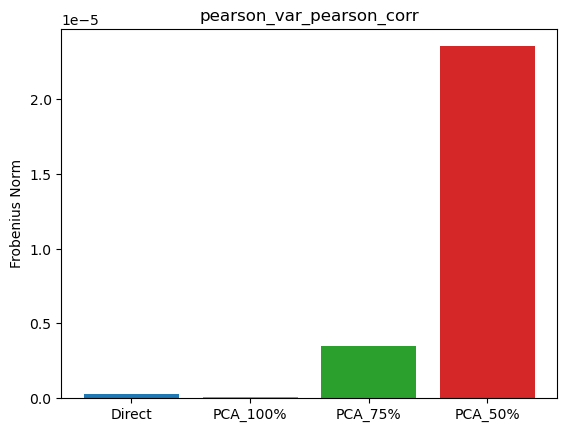

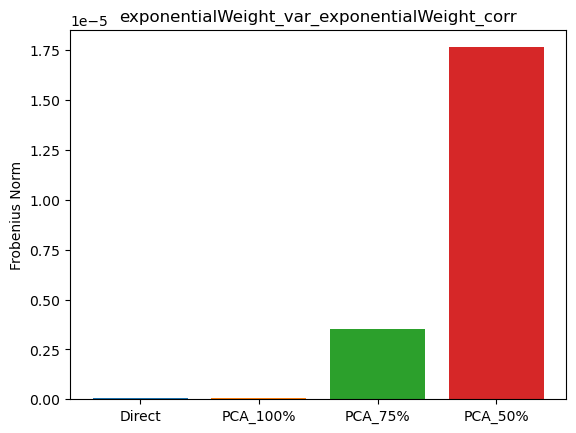

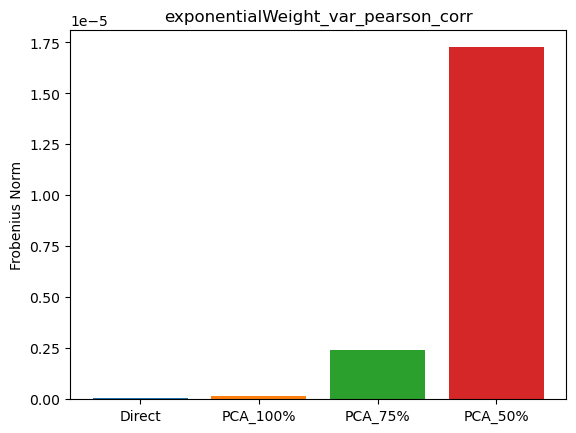

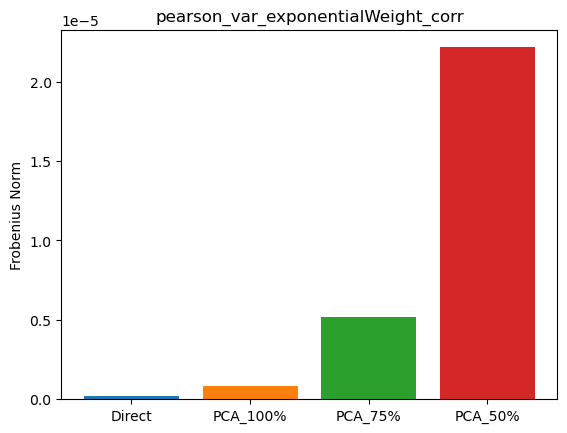

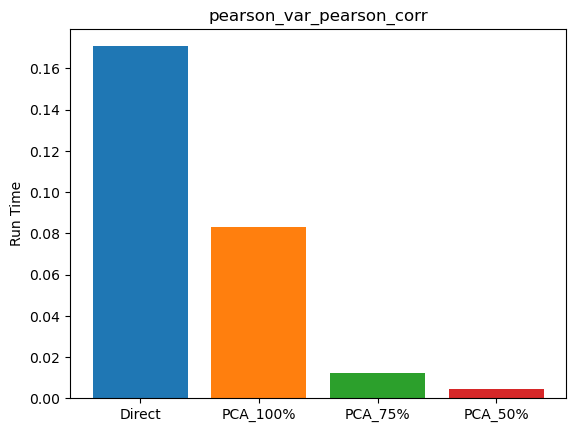

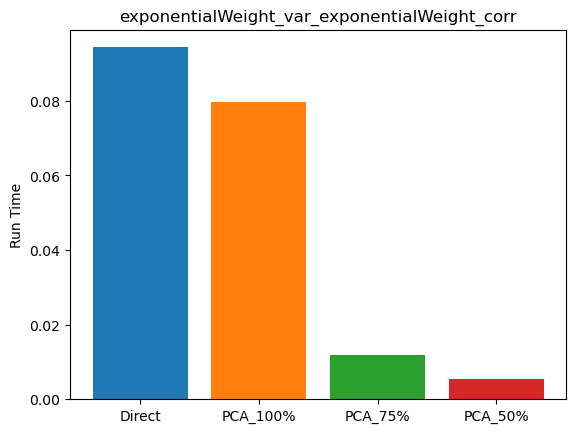

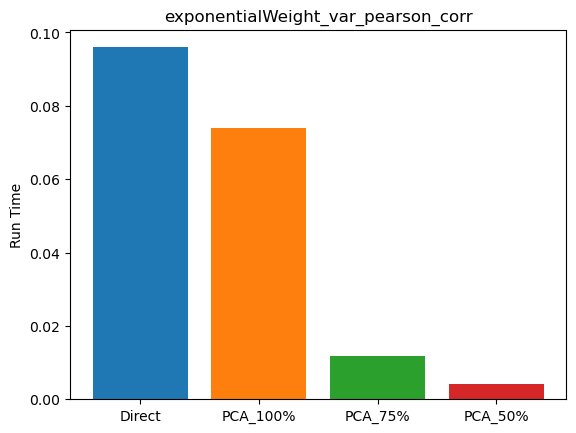

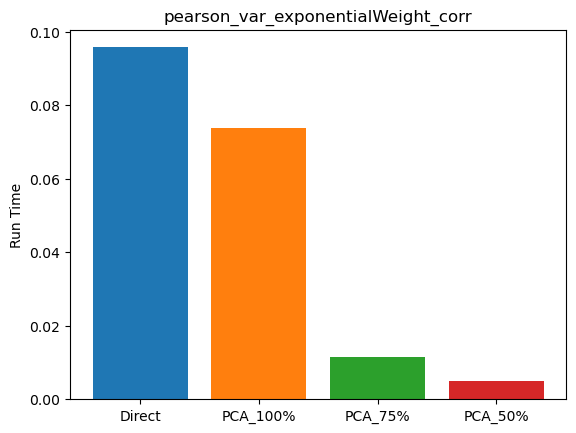

In [135]:
four_cov = [ps_var_ps_cor, ew_var_ew_cor, ew_var_ps_cor, ps_var_ew_cor]
four_cov_title = ["pearson_var_pearson_corr", "exponentialWeight_var_exponentialWeight_corr", "exponentialWeight_var_pearson_corr", "pearson_var_exponentialWeight_corr"]
four_simu = ["direct_simu", "pca_100%", "pca_75%", "pca_50%"]
lst_run_time = []
lst_l2_norm = []
for i in range(len(four_cov)):
    t1, f1 = direct_sim(four_cov[i])
    t2, f2 = pca_sim(four_cov[i], 1)
    t3, f3 = pca_sim(four_cov[i], 0.75)
    t4, f4 = pca_sim(four_cov[i], 0.5)
    lst_run_time.append([t1, t2, t3, t4])
    lst_l2_norm.append([f1, f2, f3, f4])

for i in range(len(four_cov)):
    plt.figure(i)
    plt.title(four_cov_title[i])
    plt.ylabel("Frobenius Norm")
    plt.bar("Direct", lst_l2_norm[i][0])
    plt.bar("PCA_100%", lst_l2_norm[i][1])
    plt.bar("PCA_75%", lst_l2_norm[i][2])
    plt.bar("PCA_50%", lst_l2_norm[i][3])
    plt.show()

for i in range(len(four_cov)):
    plt.figure(i)
    plt.title(four_cov_title[i])
    plt.ylabel("Run Time")
    plt.bar("Direct", lst_run_time[i][0])
    plt.bar("PCA_100%", lst_run_time[i][1])
    plt.bar("PCA_75%", lst_run_time[i][2])
    plt.bar("PCA_50%", lst_run_time[i][3])
    plt.show()

In [136]:
print("lst_run_time:")
for row in lst_run_time:
    print("{:<20} {:<20} {:<20} {:<20}".format(*row))

print("\nlst_l2_norm:")
for row in lst_l2_norm:
    print("{:<20} {:<20} {:<20} {:<20}".format(*row))

lst_run_time:
0.17067313194274902  0.08292698860168457  0.012156963348388672 0.004511833190917969
0.09436702728271484  0.07974505424499512  0.011738777160644531 0.005311012268066406
0.0959620475769043   0.07384109497070312  0.011853694915771484 0.0042591094970703125
0.09572601318359375  0.07374429702758789  0.01146697998046875  0.005040884017944336

lst_l2_norm:
3.183727834567709e-07 6.616203483146243e-08 3.4857782102811752e-06 2.351997612965315e-05
7.224477238878208e-08 4.328559993256286e-08 3.527243685913115e-06 1.7649199429749644e-05
6.902460517022156e-08 1.3884111124968678e-07 2.41958075859321e-06 1.7259300151128448e-05
1.8646328659035205e-07 8.373838843591158e-07 5.200520752000887e-06 2.2169243732345285e-05
